In [1]:
from utils import *

In [2]:
# Config plotting:
mpl.rcParams['ps.useafm'] = True                                                     
mpl.rcParams['pdf.fonttype'] = 3
mpl.rcParams['figure.figsize'] = (10, 5)

### Let's load the observation

In [3]:
idir = 'outputs'

In [4]:
# Load the obsdB 
context = Context(f'{idir}/context.yaml')
obs = context.obsdb.get()

The context file specifies how to load the data and it calls preprocess_configs.yaml in which: 
- ${\tt AxisManager \ (aman)}$ - container class for numpy arrays and similar structures, that tracks relationships between axes. For example, one element can be the TOD signal, with axes $N_{dets}$ and $N_{samp}$; another can be the timestamps, with axis $N_{samp}$. If you want to get rid of a given timestamp, the equivalent sample will also be deleted in the TOD signal when you apply the filter along the axis $N_{samp}$. 
- ${\tt process\_pipe}$ - specifies the different operations and filters applied to the data in the form of:
   - ${\tt calc}$ - makes an array that is merged into the aman file by creating a new axis
   - ${\tt process}$ - uses selected modes to subtract modes from the data 

In [5]:
# Inspect what is in the obsdb (e.g. check the first)
print(obs[0])

OrderedDict([('obs_id', '1751342400_ST1_f090_1'), ('timestamp', 1751342400.0), ('duration', 1197.9749999046326), ('start_time', 1751342400.0), ('stop_time', 1751343597.975), ('telescope', 'SAT1'), ('tel_tube', 'ST1'), ('wafer_slots', 'w25'), ('target', 'south'), ('toast_obs_name', 'south-0-0'), ('toast_obs_uid', 959754943), ('el_nom', 0.9599310885968813), ('el_span', 0.0), ('az_nom', 2.14239165693686), ('az_span', 0.5047423550479067)])


I.e. for each observation we have: the site (Atacama), the telescope (SAT1), the observed patch spanning given ra-dec coordinates, the timestamp in Unix computing time (ctime), info about the azimuth, the elevation.

In [6]:
# Select an observation to load
obs_idx = 0 #first observation 
this_obs = obs[obs_idx]
obs_id = this_obs['obs_id']

In [7]:
group = context.obsfiledb.get_detsets(obs_id)
print(group) # one wafer to process, e.g. 25 x 90 GHz

['w25_f090']


The groups specify the frequency of the observations (MF = middle frequency, F1 = frequency 1), and the wafer number. Here we have the 2 SO-SAT middle frequencies (90 and 150 GHz) and 7 waifers.

In [8]:
# Load data
aman = context.get_obs(obs_id, detsets=group)

In [9]:
aman

AxisManager(timestamps[samps], boresight*[samps], signal[dets,samps], hwp_angle[samps], toast_focalplane[dets], obs_info*, focal_plane*[dets], det_info*[dets], dets:LabelAxis(108), samps:OffsetAxis(47920))

Each item in the aman is an array with axes $[N_1, N_2]$. When an item has a $^*$ it means that it's itself another aman object, e.g.:

In [10]:
aman.boresight

AxisManager(az[samps], el[samps], roll[samps], samps:OffsetAxis(47920))

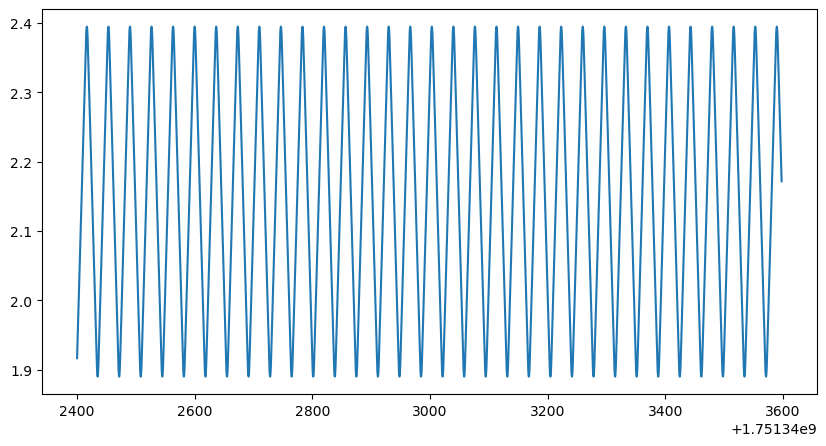

In [11]:
# Let's plot the boresight azimuth: we expect it to go up and down in
# as the specified region inside the North/South SAT patch is scanned
plt.plot(aman.timestamps,aman.boresight.az)

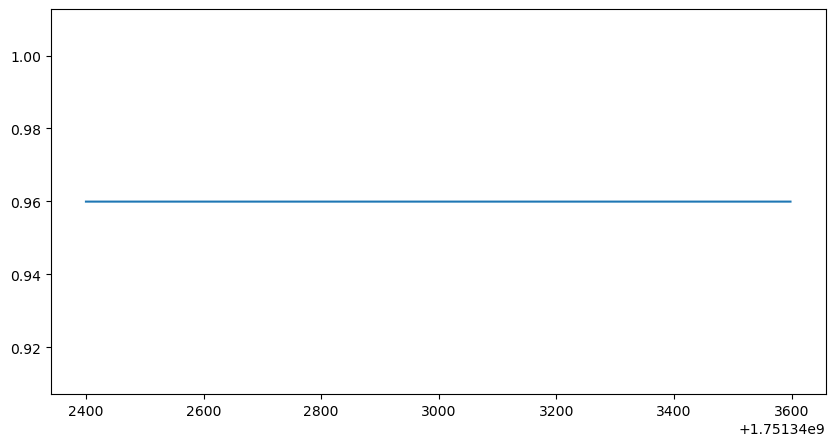

In [12]:
# Let's plot the boresight elevation: we expect it to be approximately 
# constant, except at the edges where it goes up and down to calibrate 
# depending on the temperature perceived at different altitudes.
plt.plot(aman.timestamps, aman.boresight.el)

In [13]:
# Let's get rid of the edges
si, ei = 2000, -2000
#plt.plot(aman.boresight.el[si:ei])

In [14]:
# Apply this restriction to all the objects 
# along a given axis
aman.restrict('samps', (si,ei))

AxisManager(timestamps[samps], boresight*[samps], signal[dets,samps], hwp_angle[samps], toast_focalplane[dets], obs_info*, focal_plane*[dets], det_info*[dets], dets:LabelAxis(108), samps:OffsetAxis(43920))

Note that ${\tt samps}$ has gone down!

In [15]:
aman.signal.shape

(108, 43920)

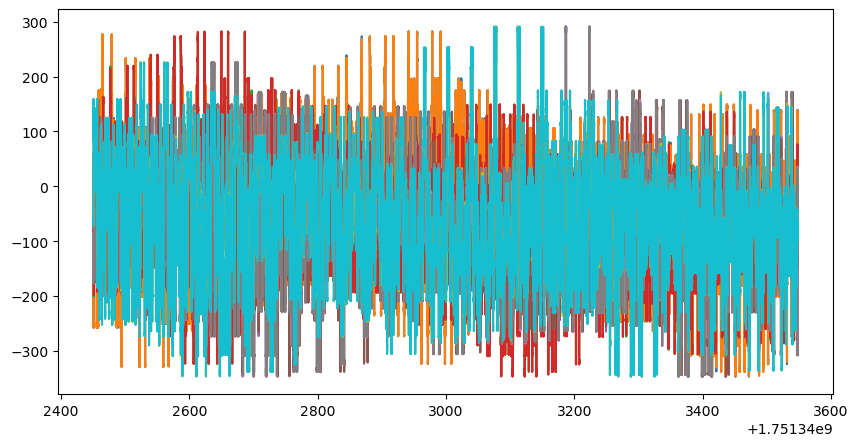

In [16]:
# Let's plot the TOD of the first 10 detectors
for i in np.arange(10):
    plt.plot(aman.timestamps, aman.signal[i])

The TODs looks quite "chunky". This is mainly due to the presence of the atmosphere. This is more visible in the PSD (below), where the bump at larger scales reflects the 1/f noise of the atmosphere.

In [17]:
# Let's calculate the PSD
freqs, Pxx = calc_psd(aman)

If we merge, i.e. ${\tt calc\_psd(aman,merge=True)}$, this creates 2 additional objects in the aman: one for the frequencies (${\tt freqs}$), and one for the 1D fourier transform or PSD (${\tt Pxx}$).

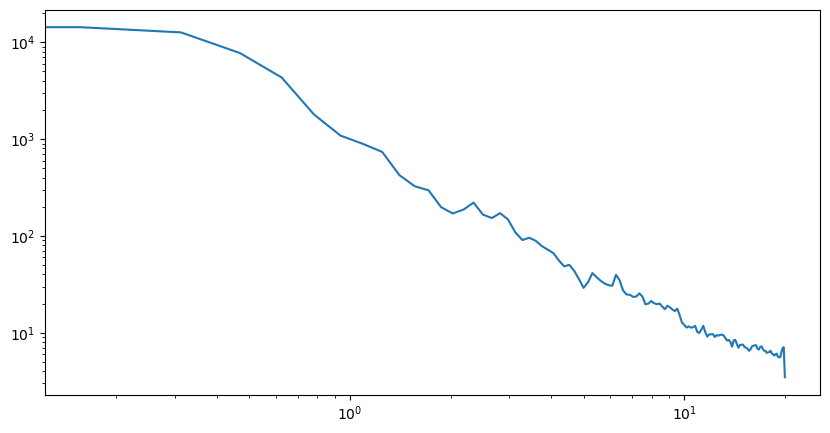

In [18]:
# And plot it for the first detector
plt.loglog(freqs,Pxx[0])

By inspecting the PSD, we don't see any HWP synchronous signal, which would appear as a series of repetitive peaks at different frequencies, which implies no HWPSS was included in the sim. We also don't see any evident glitches in the TOD. Therefore, we can create a config file for the filters, without including any HWP demodulation, nor operations/filters to correct for the aformentioned effects. 

### Apply the "filters"

In [19]:
from sotodlib.site_pipeline.preprocess_tod import _build_pipe_from_configs
from sotodlib.site_pipeline.preprocess_tod import _get_preprocess_context

   0.000: Log timestamps are relative to 2023-11-19 08:32:59,059 (INFO)


A pre-processing config example can be found [here](https://github.com/simonsobs/pwg-scripts/blob/2789733d118081e4a9f6ef2abbca70b7b6e0b87c/pwg-tds/real-data-coadd/noise-data/preprocess_configs.yaml).


In [20]:
# Let's load the config file created 
configs="./preprocess/pipe_s0002_sim_preprocess.yaml"
configs = yaml.safe_load(open(configs, "r"))

In [21]:
# And build the pipeline including the filters 
# specified in the config
pipe = _build_pipe_from_configs(configs)
proc_aman = core.AxisManager( aman.dets, aman.samps)

Let's apply each filter specified in the config, and plot the effects on the data.

In [22]:
# 1) Detrended
pi = 0
process = pipe[pi]
print(f"Processing {process.name}")
process.process(aman, proc_aman)
process.calc_and_save(aman, proc_aman)

Processing detrend


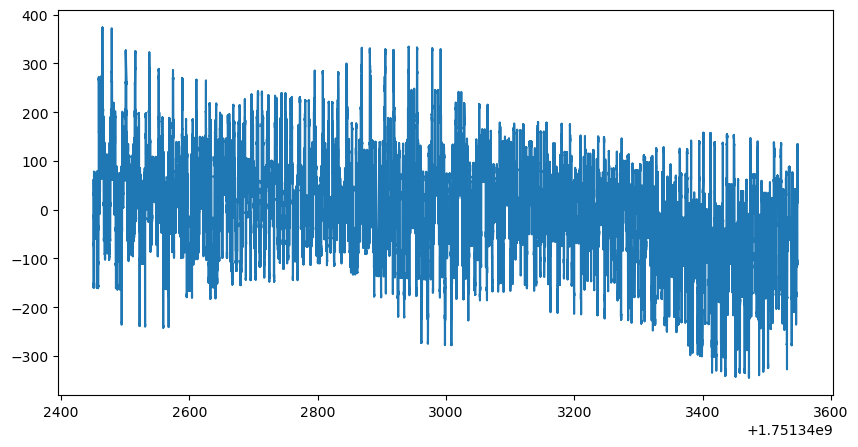

In [23]:
plt.plot(aman.timestamps, aman.signal[0])

Detrending means that one straight line is fit between the beginning and the end of the TOD (it will be an oblique line), and this line is subtracted from the data, such that initial and final point of the TOD will have the same y-value.

In [24]:
# 2) Apodize (a.k.a. deslope in the mapmakers)
pi = 1
process = pipe[pi]
print(f"Processing {process.name}")
process.process(aman, proc_aman)
process.calc_and_save(aman, proc_aman)

Processing apodize


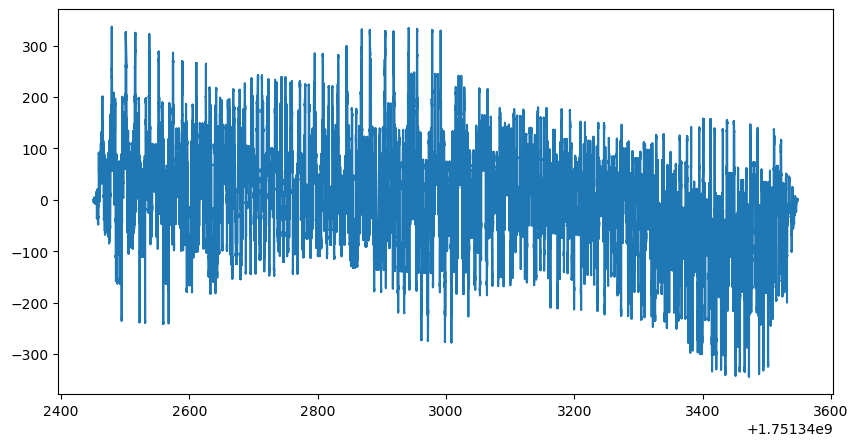

In [25]:
plt.plot(aman.timestamps, aman.signal[0])

This is similar to the kind of apodization process that you would apply to the maps at the edges of the mask. In practice, you are applying a cosine filter at the edges of the TOD (the edges are in fact different from the previous plot). 

### Demodulate and make maps

In [26]:
# 3) Demodulate
pi = 2
process = pipe[pi]
print(f"Processing {process.name}")
process.process(aman, proc_aman)
process.calc_and_save(aman, proc_aman)

Processing demodulate


Demodulating means you shift the peak where the polarization signal is in frequency (on the right/away from the 1/f bump of the atmosphere) back to the centre of the frequency axis and you filter cut away everything that is on smaller scales compared to that.

It returns dsT, demodQ, demodU. dsT is the non-demodulated T signal, while the rest is the demodulated Q/U polarization signal, where the atmosphere is taken care of. The latter should therefore look like white noise. 

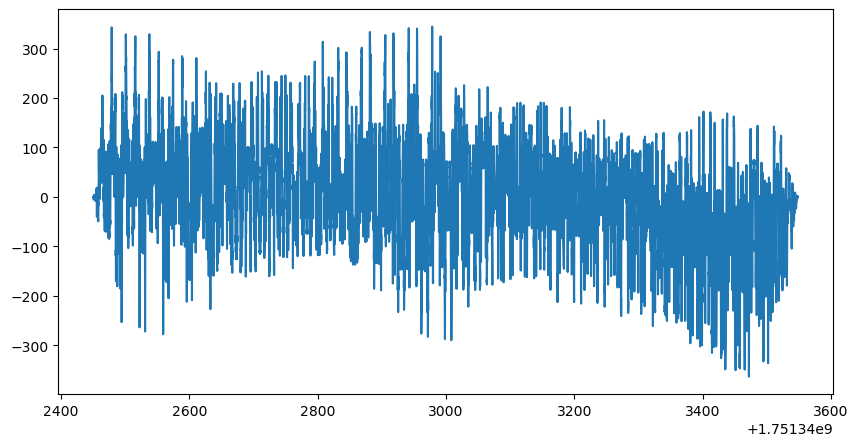

In [27]:
plt.plot(aman.timestamps, aman.dsT[0])

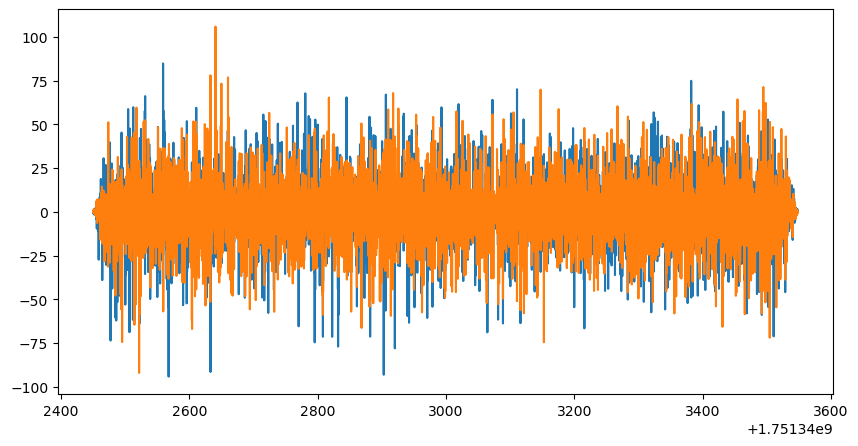

In [28]:
plt.plot(aman.timestamps, aman.demodQ[0])
plt.plot(aman.timestamps, aman.demodU[0])

In [29]:
freqs, Pxx_T = calc_psd(aman=aman, signal=aman.dsT)
_, Pxx_Q = calc_psd(aman=aman, signal=aman.demodQ)
_, Pxx_U = calc_psd(aman=aman, signal=aman.demodU)

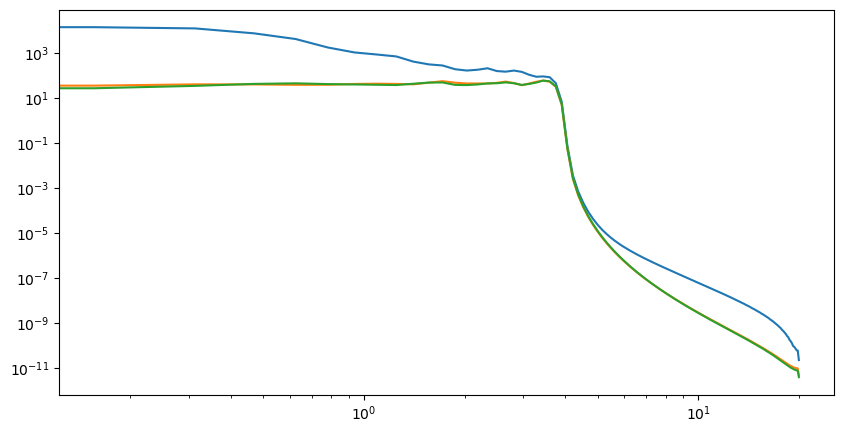

In [30]:
plt.loglog(freqs,Pxx_T[0])
plt.loglog(freqs,Pxx_Q[0])
plt.loglog(freqs,Pxx_U[0])

It does indeed look like white noise for the demodulated Q and U below freq < 4 Hz! This obviously happens because the demodulation does a low pass filter below 4 Hz

In [ ]:
#demod.make_map?

#### Mapmaker (implemented in sotodlib)

In [31]:
# Make map
from sotodlib.coords import demod
from sotodlib import coords
res = (1./6.)*coords.DEG # select resolution 
map_dict = demod.make_map(aman, res=res, dsT=aman.dsT, demodQ=aman.demodQ, demodU=aman.demodU, wrong_definition=False)

In [32]:
map_dict.keys()

dict_keys(['map', 'weighted_map', 'weight'])

- "Unweighted" map, i.e. map of temperature and polarization;
- Weighted map, i.e. the inverse variance weighted map of temperature and polarization;
- Weights applied, i.e. the map of inverse variance weights used in the map-making process.

In [33]:
from pixell import enmap, enplot
from pixell import enplot
def eshow(x,**kwargs): enplot.show(enplot.plot(x,**kwargs))

Text(0.5, 1.0, 'Total U')

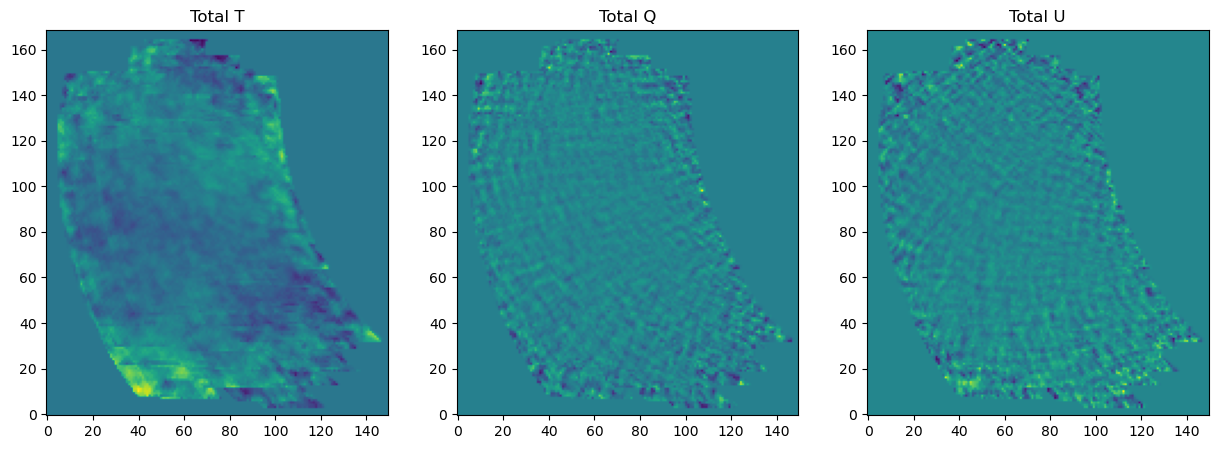

In [34]:
fig, axes = plt.subplots(1,3,figsize = (15,5))
ax = axes.flatten()
for _i,_m in enumerate(map_dict['map']):
    ax[_i].imshow(_m, origin='lower')
ax[0].set_title('Total T')
ax[1].set_title('Total Q')
ax[2].set_title('Total U')

These maps include the filters and can be used into BBMaster.

Text(0.5, 1.0, 'Weighted U')

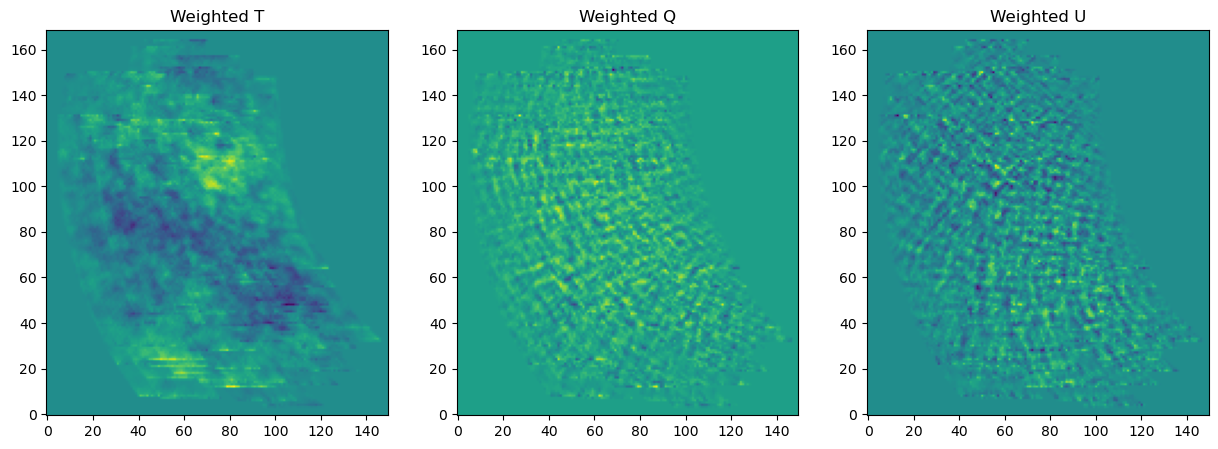

In [35]:
fig, axes = plt.subplots(1,3,figsize = (15,5))
ax = axes.flatten()
for _i,_m in enumerate(map_dict['weighted_map']):
    ax[_i].imshow(_m, origin='lower')
ax[0].set_title('Weighted T')
ax[1].set_title('Weighted Q')
ax[2].set_title('Weighted U')

In [36]:
map_dict['weight'].shape

(3, 3, 169, 150)

In [37]:
map_dict['weighted_map'].shape

(3, 169, 150)

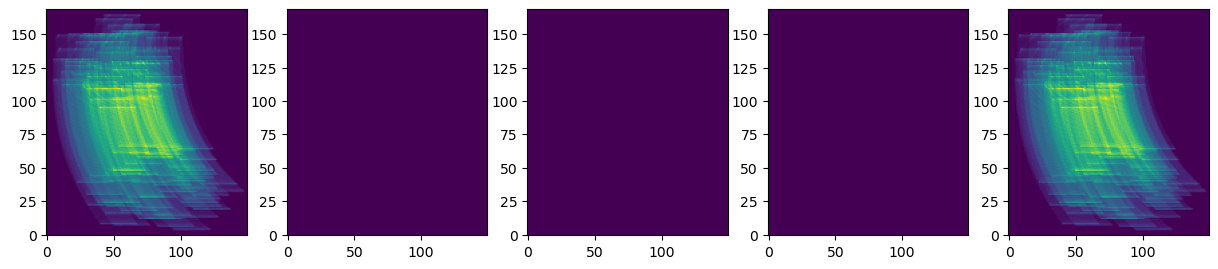

In [38]:
fig, axes = plt.subplots(1,5,figsize = (15,5))
ax = axes.flatten()
for _i,_m in enumerate(map_dict['weight']):
    for _j,_n in enumerate(map_dict['weight']):
        ax[_i+_j].imshow(map_dict['weight'][_i,_j,:,:], origin='lower')

### Run the SAT mapmaker

In [39]:
# write the observation to a file, we only want to run this observation alone
file = open('tod_list_test.txt','w')
file.write('%s\n'%obs_id)
file.close()

In [ ]:
# run the mapmaker. We need a context, a query, a geometry, an output dir
# advact_car_fejer1_10arcmin.fits is a full sky geometry with 10 arcmin pixels

# this SAT mapmaker can be run having this branch of sotodlib installed https://github.com/simonsobs/sotodlib/tree/SAT-mapmaking

# Run this on the terminal
# OMP_NUM_THREADS=4 mpiexec -n 2 so-site-pipeline filterbin-mapmaker outputs/context.yaml tod_list_test.txt advact_car_fejer1_10arcmin.fits outputs --tasks-per-group 2

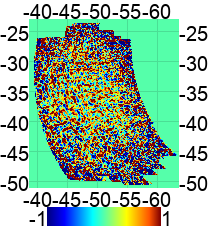

In [41]:
# we plot the Q map created in this notebook
params = {"color":"wmap", "ticks":5, "downgrade":1, "colorbar":True, "range":1}
eshow(map_dict['map'][1], **params)

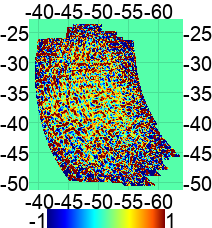

In [42]:
from pixell import enmap
map_mapmaker = enmap.read_map('outputs/17513/atomic_1751342400_w25_f090_map.fits')

params = {"color":"wmap", "ticks":5, "colorbar":True, "range":1, "upgrade":1}
eshow(map_mapmaker[1], **params)

### Plot detectors

In [ ]:
# Most angles are in radians
DEG = np.pi/180

In [ ]:
# Plot the (ra, dec) of some detectors.
radec = coords.get_radec(tod=aman)
plt.figure(figsize=(4, 4))
dets = [10, 200]
for det_idx in dets:
    ra, dec = radec[det_idx,:,:2].transpose()
    plt.plot(ra/DEG, dec/DEG)
    plt.scatter([ra[0]/DEG], [dec[0]/DEG], marker='x')
plt.gca().invert_xaxis()
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')

### Reproject into healpix

In [ ]:
import pixell
pixell.__version__

In [ ]:
import healpy as hp
from pixell import enmap, enplot, utils, coordinates #reproject #wcsutils

In [ ]:
m_hp = map_dict['map'][0,:,:].to_healpix(nside=512, order=0)
w_hp = map_dict['weight'][0,0,:,:].to_healpix(nside=512, order=0)
mt_hp = map_dict['weighted_map'][0,:,:].to_healpix(nside=512, order=0)

In [ ]:
plt.figure()
hp.mollview(w_hp, xsize=512, coord='C')
hp.graticule(15, verbose=False)
plt.savefig(f'{idir}/weight_hp.png')

In [ ]:
plt.figure()
hp.mollview(m_hp, xsize=512, coord='C')
plt.savefig(f'{idir}/map_hp.png')

In [ ]:
plt.figure()
hp.mollview(mt_hp, xsize=512, coord='C')
hp.graticule(15, verbose=False)
plt.savefig(f'{idir}/weightedmap_hp.png')

#### Continue to the next section

Go to [Section 6 - Master Pipeline](Sec6_Master_pipeline.ipynb).